In [1]:
!wget --no-check-certificate https://storage.googleapis.com/laurencemoroney-blog.appspot.com/horse-or-human.zip -O /content/horse-or-human.zip
!wget --no-check-certificate https://storage.googleapis.com/laurencemoroney-blog.appspot.com/validation-horse-or-human.zip -O /content/validation-horse-or-human.zip 

--2023-02-26 17:42:39--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/horse-or-human.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.145.128, 108.177.127.128, 142.251.31.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.145.128|:443... connected.
HTTP request sent, awaiting response... 404 Not Found
2023-02-26 17:42:40 ERROR 404: Not Found.

--2023-02-26 17:42:40--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/validation-horse-or-human.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.145.128, 108.177.127.128, 142.251.31.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.145.128|:443... connected.
HTTP request sent, awaiting response... 404 Not Found
2023-02-26 17:42:40 ERROR 404: Not Found.



In [1]:
from IPython.display import clear_output
!pip install --upgrade kaggle
clear_output()
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))
  
# Then move kaggle.json into the folder where the API expects to find it.
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 74 bytes


In [2]:
!kaggle datasets download -d sanikamal/horses-or-humans-dataset

 99% 304M/307M [00:16<00:00, 21.0MB/s]
100% 307M/307M [00:16<00:00, 19.3MB/s]


In [3]:
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Dropout
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
import os
import zipfile

local_zip = '/content/horse-or-human.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/content/training')

local_zip = '/content/validation-horse-or-human.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/content/validation')

In [4]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [5]:
!unzip -xq '/content/horses-or-humans-dataset.zip' 


In [6]:
train_dir = '/content/horse-or-human/train'
validation_dir = '/content/horse-or-human/validation'

In [7]:
train_datagen = ImageDataGenerator(
    rescale = 1/255.,
    rotation_range = 40,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True
)

test_datagen = ImageDataGenerator(
    rescale = 1/255.
)

In [8]:
train_generator =  train_datagen.flow_from_directory(
    train_dir,
    batch_size = 64,
    class_mode = 'binary',
    target_size = (160,160)
)

test_generator =  test_datagen.flow_from_directory(
    validation_dir,
    batch_size = 64,
    class_mode = 'binary',
    target_size = (160,160)
)

Found 1027 images belonging to 2 classes.
Found 256 images belonging to 2 classes.


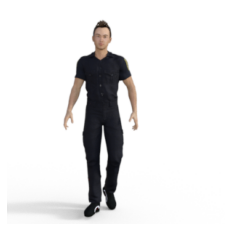

In [10]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
img = cv2.imread('/content/horse-or-human/validation/humans/valhuman01-01.png')[:,:,::-1]
img = np.expand_dims(img, axis = 0)
plt.imshow(img[0])
plt.axis('off')
plt.show()

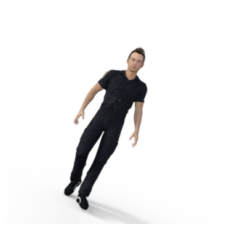

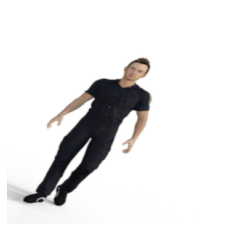

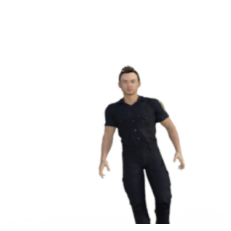

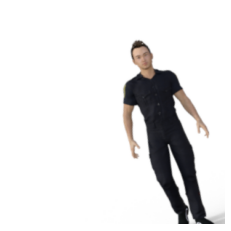

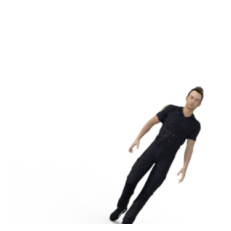

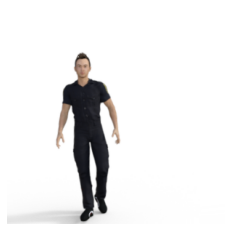

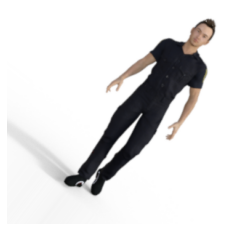

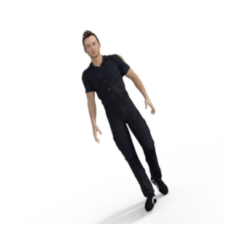

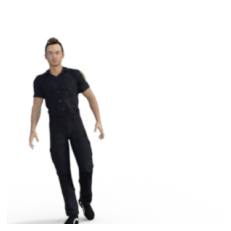

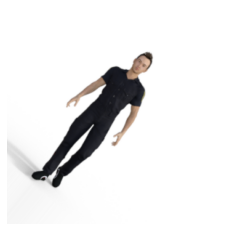

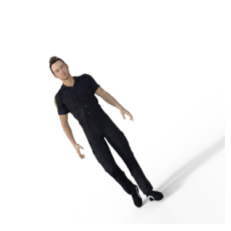

In [11]:
i = 0
for batch in train_datagen.flow(x = img, batch_size = 1):
  plt.imshow(batch[0])
  plt.axis('off')
  plt.show()
  i = i+1
  if i >10:
    break

In [12]:
from tensorflow.keras.applications import MobileNetV2
#BackBone
pre_trained_model = MobileNetV2(
    include_top = False,
    weights = None,
    input_shape = (160,160,3),
    pooling = max
)

In [ ]:
# pre_trained_model.summary()

In [ ]:
# from keras.utils import plot_model
# plot_model(pre_trained_model)

In [13]:
print(len(pre_trained_model.layers))
for layer in pre_trained_model.layers:
  layer.trainable = False

154


In [14]:
# pre_trained_model.summary()

In [15]:
len(pre_trained_model.layers)

154

In [16]:
last_layer = pre_trained_model.get_layer('out_relu')
last_output = last_layer.output

In [17]:
from keras.models import Model

In [18]:
x = Flatten()(last_output)
x = Dense(units = 64, activation='relu')(x)
x = Dropout(0.2)(x)
out_x = Dense(1, activation = 'sigmoid')(x)

In [19]:
model = Model(pre_trained_model.input , out_x)

In [20]:
model.compile(optimizer = Adam(learning_rate = 0.0001),
              loss = 'binary_crossentropy',
              metrics = ['accuracy'])

In [21]:
# model.summary()

In [22]:
#model checkpoint
from tensorflow.keras.callbacks import ModelCheckpoint
check_point_path = '/content/models/best.h5'
model_checkpoint_callback = ModelCheckpoint(
    filepath = check_point_path,
    monitor='val_accuracy',
    save_weights_only=False,
    save_best_only=True,
    verbose = 1
)

In [23]:
print('Num Params : ',model.count_params())
history = model.fit(
    train_generator,
    epochs=5,
    verbose=1,
    validation_data=test_generator,
    callbacks = [model_checkpoint_callback]
)

Num Params :  4306113
Epoch 1/5
17/17 [==============================] - ETA: 0s - loss: 0.6932 - accuracy: 0.5005
Epoch 1: val_accuracy improved from -inf to 0.50000, saving model to /content/models/best.h5
17/17 [==============================] - 25s 788ms/step - loss: 0.6932 - accuracy: 0.5005 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 2/5
17/17 [==============================] - ETA: 0s - loss: 0.6931 - accuracy: 0.5131
Epoch 2: val_accuracy did not improve from 0.50000
17/17 [==============================] - 12s 683ms/step - loss: 0.6931 - accuracy: 0.5131 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 3/5
17/17 [==============================] - ETA: 0s - loss: 0.6931 - accuracy: 0.5131
Epoch 3: val_accuracy did not improve from 0.50000
17/17 [==============================] - 12s 689ms/step - loss: 0.6931 - accuracy: 0.5131 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 4/5
17/17 [==============================] - ETA: 0s - loss: 0.6931 - accuracy: 0.5131
Epoch 4: val_ac

In [24]:
model.evaluate(train_generator)

17/17 [==============================] - 11s 634ms/step - loss: 0.6931 - accuracy: 0.5131


[0.6931195259094238, 0.5131450891494751]

In [25]:
model.evaluate(test_generator)

4/4 [==============================] - 1s 185ms/step - loss: 0.6931 - accuracy: 0.5000


[0.6931477785110474, 0.5]

In [26]:
pred = model.predict(test_generator)

4/4 [==============================] - 1s 184ms/step


In [31]:
import keras.utils as image
from keras.preprocessing import image


In [39]:
import numpy as np
from google.colab import files
from keras.preprocessing import image

from tensorflow.keras.utils import load_img, img_to_array 
import keras.utils as image
from keras.preprocessing import image
import tensorflow as tf

uploaded = files.upload()

for fn in uploaded.keys():
    # predicting images
    path = '/content/' + fn
    img = tf.keras.utils.load_img(path, target_size=(160,160))
    x = img_to_array(img)
    x = np.expand_dims(x, axis=0) / 255.
    classes = model.predict(x, batch_size=10)
    print(classes[0])
    if classes[0]>0.5:
        print(fn + " is a human")
    else:
        print(fn + " is a horse")

Saving 0b7f4e9b-f59c-4024-9f06-b3dc12850ab7-1920-1080.jpg to 0b7f4e9b-f59c-4024-9f06-b3dc12850ab7-1920-1080 (9).jpg
1/1 [==============================] - 1s 970ms/step
[0.5005381]
0b7f4e9b-f59c-4024-9f06-b3dc12850ab7-1920-1080.jpg is a human
